In [1]:
import webotsgym as wg

from webotsgym.config import WebotConfig, SimSpeedMode
from webotsgym.environment import WebotsEnv, WebotsGrid
from webotsgym.evaluate import Evaluate, EvaluateMats, EvaluatePJ0
from webotsgym.action import DiscreteAction, ContinuousAction, GridAction
from webotsgym.observation import Observation,GridObservation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gym
from gym import spaces
import stable_baselines
from stable_baselines import A2C, ACER, ACKTR, DQN, DDPG, SAC, PPO1, PPO2, TD3, TRPO
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.policies import MlpPolicy

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
class MyGridObservation(GridObservation):
    def __init__(self, env):
        super(GridObservation, self).__init__(env)

    @property
    def observation_space(self):
        return spaces.Box(-np.inf, np.inf, shape=(9,),
                          dtype=np.float32)

    def get(self):
        arr = np.empty(0)
        arr = np.hstack((arr, self.gps_actual))
        arr = np.hstack((arr, self.gps_target))
        arr = np.hstack((arr, self.lidar))
        arr = np.hstack((arr, np.array(self.env.state._action_denied)))
#         arr = np.hstack((arr, np.array(self.env.gps_visited_count)))
        return arr

class MyWebotsGrid(WebotsGrid):
    def __init__(self, seed=None, gps_target=(1, 1),
                 train=False, evaluate_class=Evaluate,
                 config: WebotConfig = WebotConfig(),observation_class=MyGridObservation):
        config.world_scaling = 0.5
        super(WebotsGrid, self).__init__(seed=seed,
                                         gps_target=gps_target,
                                         train=train,
                                         action_class=GridAction,
                                         evaluate_class=evaluate_class,
                                         observation_class=MyGridObservation,
                                         config=config)
        len = int(config.world_size * config.world_scaling) * 2 + 1
        self.visited_count = np.zeros((len, len))
        self.time_steps = 0


In [3]:
config = WebotConfig()
config.sim_mode = SimSpeedMode.FAST
config.reset_env_after = 20000
config.num_obstacles = 16
config.world_size = 8


In [4]:
def predict(env, seed, model, steps=100, render=False, unsolve_val=110, crash_val=120):    
    obs = env.reset(seed)
    for i in range(steps):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)

        if env.get_target_distance() < 0.1:
            return i
        if env.state._touching:
            return crash_val
        
    return unsolve_val

In [5]:
# model loading
model1 = PPO1.load("models/keep/comparison_timesteps/{}".format("PPO_40k_4sensors_N=10_seed=1_obs=3x1"))
model2 = PPO1.load("models/keep/comparison_timesteps/{}".format("PPO_80k_4sensors_N=10_seed=1_obs=3x1"))
models = [model1, model2]
names = ["40k", "80k"]


env = MyWebotsGrid(train=True, 
                 config=config,
                 observation_class=MyGridObservation)
env.send_data_request()
obs = env.observation
res_all = np.empty((0, len(models)))

num_of_steps = 10
num_of_envs = 10

for env_seed in range(num_of_envs):
    res_env = np.empty(len(models))
    for model in models:
        res_env[models.index(model)] = predict(env, env_seed, model, num_of_steps)
    res_all = np.vstack((res_all, res_env))
    
df = pd.DataFrame(res_all)
df.columns = names





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Accepting on Port:  10201
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2
sending: start env 2


In [6]:
df_analysis = df.copy()
df_analysis["all"] = df_analysis.sum(axis=1)
df_analysis["seed"] = range(num_of_envs)
df_analysis.sort_values("all", ascending=False)

,40k,80k,all,seed
0,110.0,110.0,220.0,0
1,110.0,110.0,220.0,1
2,110.0,110.0,220.0,2
3,110.0,110.0,220.0,3
4,110.0,5.0,115.0,4
8,9.0,6.0,15.0,8
9,8.0,6.0,14.0,9
5,7.0,5.0,12.0,5
7,6.0,5.0,11.0,7
6,4.0,4.0,8.0,6


In [7]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

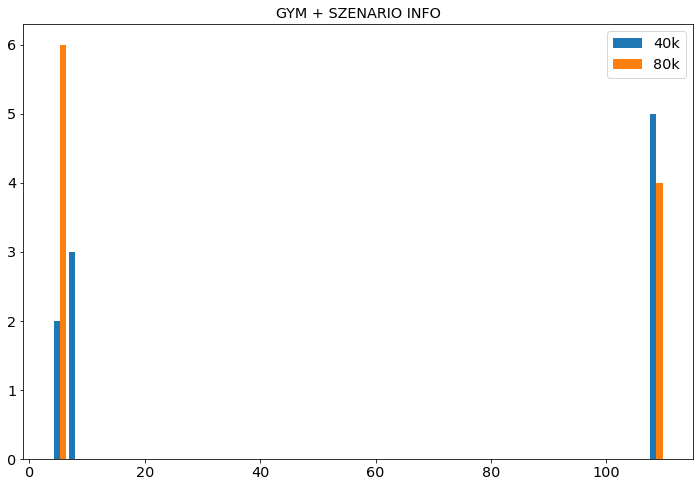

In [8]:
plt.figure(figsize=(12,8))
plt.hist(df.values, 40, histtype='bar', label=names)
plt.title('GYM + SZENARIO INFO')
plt.legend()
plt.show()